### Imports

In [1]:
import pandas as pd
import os
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
import random
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras import optimizers
import cv2 as cv

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Functions for creating the datasets

In [3]:
def generate_image_pairs(num_characters, num_instances, to_path):
    pairs = []
    
    # Pairs of same characters (target = 1)
    for c in range(1, num_characters + 1):
        for i in range(1, num_instances):
            for j in range (i + 1, num_instances + 1):
                pairs.append([to_path(c, i), to_path(c, j), 1])
    
    # Calculations for having approximately same number of positive and negative pairs
    T = len(pairs)
    N = (num_characters - 1) * num_characters // 2
    C = T / N
    C = round(C)
    
    # Pairs of different characters (target = 0)
    for i in range(1, num_characters):
        for j in range (i + 1, num_characters + 1):
            for _ in range(C):
                f = random.randint(1, num_instances)
                s = random.randint(1, num_instances)
                pairs.append([to_path(i, f), to_path(j, s), 0])
            
    return pairs

def create_data_df(num_characters, num_instances, to_path):
    pairs = generate_image_pairs(num_characters, num_instances, to_path)
    return pd.DataFrame(pairs, columns =['First', 'Second', 'Target'])

def load_images(file_paths):
    images = []
  
    for file_path in file_paths:
        images.append(cv.imread(file_path, cv.IMREAD_GRAYSCALE))
    return images

def normalize_data(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

## Function for feature engineering

In [4]:
def create_features(first_images, second_images, labels, drawRandom = False):
    sift = cv.xfeatures2d.SIFT_create()
    bf = cv.BFMatcher()
    
    features = []

    rn_idx = random.randint(0, len(labels))
    
    for i in range(len(first_images)):
        kp_1, desc_1 = sift.detectAndCompute(first_images[i], None)
        kp_2, desc_2 = sift.detectAndCompute(second_images[i], None)
        if len(kp_1) > 0 and len(kp_2) > 0:
            matches = bf.knnMatch(desc_1, desc_2, k=2)

        distances = []
        good = []
        try:
            for m,n in matches:
                if m.distance < 0.75 * n.distance:
                    distances.append(m.distance)
                    good.append([m])
        except:
            print('Can not detect mathes on image pair.')
            
        distances.sort()
        distances = distances[:9]
        distances = distances + [1000] * (9 - len(distances))
        distances.append(len(good))
        
        features.append(distances)
        
        if (drawRandom and i == rn_idx):
            print(distances)
            out = None
            img3 = cv.drawMatchesKnn(first_images[i], kp_1, second_images[i], kp_2, good, out, flags=2)
            plt.figure(figsize = (10, 7)), plt.title(labels[i]), plt.axis('off'), plt.imshow(img3), plt.show()
        
    return features

### Lambdas for images' paths

In [5]:
to_path_mine = lambda c, i : str(c) + '/' + str(c) + '_' + str(i) + '.png' if i != 1 else str(c) + '/' + str(c) + '.png'
to_path_omniglot = lambda c, i : 'character' + str(c) + '/' + 'c (' + str(i) + ').png'

### Generating features for all alphabets


Generating features from: Cyrillic
Number of pairs per class:
0    6336
1    6270
Name: Target, dtype: int64
[238.36526489257812, 373.53045654296875, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2]


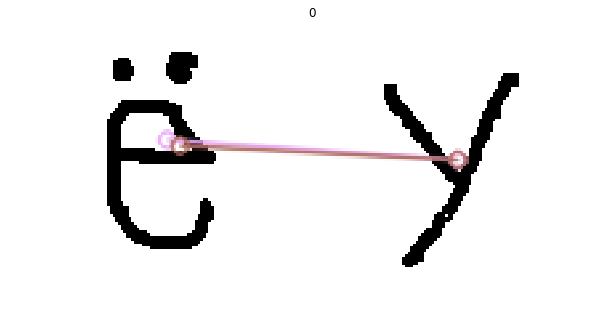


Generating features from: Alphabet of the Magi
Number of pairs per class:
1    3800
0    3800
Name: Target, dtype: int64

Generating features from: Futurama
Number of pairs per class:
1    4940
0    4875
Name: Target, dtype: int64
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.
Can not detect mathes on image pair.

Generating features from: Japanese (Katakana)
Number of pairs per class:
1    8930
0    8648
Name: Target, dtype: int64

Generating features from: Sanskrit
Number of pairs per class:
1    7980
0    7749
Name: Target, dtype: int64

Generating features from: Armenian
Number of pairs per class:
1    5700
0    5655
Name: Target, dtype: int64


In [6]:
alphabet_paths = [('E:/Alphabets Project/Cyrillic', 33, 20, to_path_omniglot), \
                  ('E:/Alphabets Project/Alphabet of the Magi', 20, 20, to_path_omniglot), \
                  ('E:/Alphabets Project/Futurama', 26, 20, to_path_omniglot), \
                  ('E:/Alphabets Project/Japanese (Katakana)', 47, 20, to_path_omniglot), \
                  ('E:/Alphabets Project/Sanskrit', 42, 20, to_path_omniglot), \
                  ('E:/Alphabets Project/Armenian', 30, 20, to_path_omniglot)]

alphabets = [] # consist of (name, features, y) for every alphabet

draw = True
for path, c, i, to_path in alphabet_paths:
    
    print('\nGenerating features from: ' + path.split('/')[2])
    
    os.chdir(path)
    data = create_data_df(c, i, to_path)
    
    print('Number of pairs per class:')
    print(data['Target'].value_counts())
    
    X_first_images = load_images(data.First.values)
    X_second_images = load_images(data.Second.values)
    y = data.Target.values
    
    features = create_features(X_first_images, X_second_images, y, draw)
    draw = False
    
    alphabets.append((path.split('/')[2], features, y))


Generating features from: Alphabet 2l 5c
Number of pairs per class:
1    3800
0    3800
Name: Target, dtype: int64
[153.62290954589844, 177.9971923828125, 275.10906982421875, 289.0639953613281, 1000, 1000, 1000, 1000, 1000, 4]


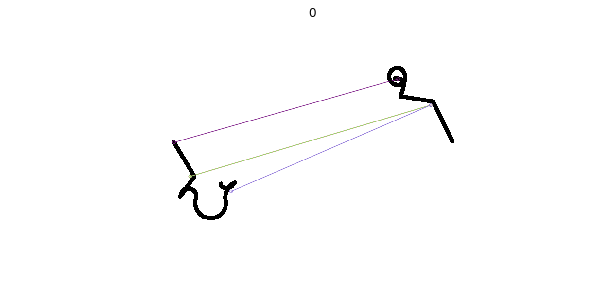


Generating features from: Alphabet 4l 2c
Number of pairs per class:
0    2450
1    2250
Name: Target, dtype: int64

Generating features from: Alphabet 4l 4c
Number of pairs per class:
1    3800
0    3800
Name: Target, dtype: int64

Generating features from: Alphabet 5l 1c
Number of pairs per class:
0    4800
1    4750
Name: Target, dtype: int64

Generating features from: Alphabet 7l 3c
Number of pairs per class:
1    3800
0    3800
Name: Target, dtype: int64

Generating features from: Alphabet 0l 7c
Number of pairs per class:
0    4800
1    4750
Name: Target, dtype: int64


In [7]:
pseudo_alphabet_paths = [('E:/Alphabets Project/Alphabet 2l 5c/Images', 20, 20, to_path_mine), \
                         ('E:/Alphabets Project/Alphabet 4l 2c/Images', 50, 10, to_path_mine), \
                         ('E:/Alphabets Project/Alphabet 4l 4c/Images', 20, 20, to_path_mine), \
                         ('E:/Alphabets Project/Alphabet 5l 1c/Images', 25, 20, to_path_mine), \
                         ('E:/Alphabets Project/Alphabet 7l 3c/Images', 20, 20, to_path_mine), \
                         ('E:/Alphabets Project/Alphabet 0l 7c/Images', 25, 20, to_path_mine)]

pseudo_alphabets = [] # consist of (name, features, y) for every alphabet

draw = True
for path, c, i, to_path in pseudo_alphabet_paths:
    
    print('\nGenerating features from: ' + path.split('/')[2])
    
    os.chdir(path)
    data = create_data_df(c, i, to_path)
    
    print('Number of pairs per class:')
    print(data['Target'].value_counts())
    
    X_first_images = load_images(data.First.values)
    X_second_images = load_images(data.Second.values)
    y = data.Target.values
    
    features = create_features(X_first_images, X_second_images, y, draw)
    draw = False
    
    pseudo_alphabets.append((path.split('/')[2], features, y))

### Function for creating the NN model

In [8]:
def nn_model(n_input):
    model = Sequential()
    model.add(Dense(32, input_dim=n_input, activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
    
    return model

In [10]:
m = nn_model(10)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 10,913
Trainable params: 10,913
Non-trainable params: 0
_________________________________________________________________


# I. Individual training of the NN for each alphabet

In [10]:
for name, features, y in alphabets:
    print("\n" + name)
    X = pd.DataFrame(features, columns = list('abcdefghij'))
    X = normalize_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=27)
    
    print("Fitting in progress...")
    standard_model = nn_model(10)
    standard_model.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose = 0, validation_split=0.2)
    
    print("Evaluation: " + str(standard_model.evaluate(X_test, y_test, verbose = 0)))


Cyrillic
Fitting in progress...
Evaluation: [0.591407112379291, 0.6840296139608673]

Alphabet of the Magi
Fitting in progress...
Evaluation: [0.614137899143654, 0.662719298245614]

Futurama
Fitting in progress...
Evaluation: [0.5596552278878126, 0.7100169779286927]

Japanese (Katakana)
Fitting in progress...
Evaluation: [0.6577104706632219, 0.608835798266895]

Sanskrit
Fitting in progress...
Evaluation: [0.6049470816610425, 0.672388217918548]

Armenian
Fitting in progress...
Evaluation: [0.6222944123009485, 0.6560023481943127]


# II. Zero shot learning for every alphabet using Reptile on the rest 

#### Defing the Reptile algorithm, it takes the test data for the alphabet that we will be predicting and the rest of the alphabets what will be used by the algorithm to tune the NN. 

In [18]:
def reptile(X_test, y_test, alphabets, weights):

    num_iters = 3
    k = 10
    sample_size = 1000
    lr = 0.15

    reptile_model = nn_model(10)
    
    if weights is not None:
        reptile_model.set_weights(weights)
        
    W = reptile_model.get_weights()

    print("\nInitial evaluation: " + str(reptile_model.evaluate(X_test, y_test, verbose = 0)) + "\n")

    for name, features, y in alphabets:

        print('Updating NN weights with: ' + name)

        X = pd.DataFrame(features, columns = list('abcdefghig'))
        X = normalize_data(X)
        
        X_full, X_eval, y_full, y_eval = train_test_split(X, y, test_size = 0.3, random_state=27)

        for iteration in range(num_iters):
           
            sample_indices = random.sample(range(len(X_full)), sample_size)
            X_sample = np.array([X_full[index] for index in sample_indices])
            y_sample = np.array([y_full[index] for index in sample_indices])

            new_model = nn_model(10)
            new_model.set_weights(W)
            new_model.fit(X_sample, y_sample, epochs = k, batch_size = 1, verbose = 0)
            _W = new_model.get_weights()

            step_size = lr * (1 - iteration / num_iters) 
            delta = np.subtract(_W, W) * step_size

            W = [sum(i) for i in zip(W, delta)] 
            
        reptile_model.set_weights(W)
        print("Evaluation: " + str(reptile_model.evaluate(X_test, y_test, verbose = 0)))

    reptile_model.set_weights(W)
    print("\nFinal evaluation: " + str(reptile_model.evaluate(X_test, y_test, verbose = 0)))

In [19]:
for name, features, y in alphabets:
    
    print("\n========== " + name)

    X = pd.DataFrame(features, columns = list('abcdefghig'))
    X = normalize_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=27)
    
    other_alphabets = list(filter(lambda a: a[0] != name, alphabets))
    
    reptile(X_test, y_test, other_alphabets, None)


========== Cyrillic

Initial evaluation: [0.6920840293878225, 0.49603384452670546]

Updating NN weights with: Alphabet of the Magi
Evaluation: [0.6734341059268183, 0.6819143310102567]
Updating NN weights with: Futurama
Evaluation: [0.6507103847549556, 0.6557377048865126]
Updating NN weights with: Japanese (Katakana)
Evaluation: [0.6459210494218964, 0.6718667371445771]
Updating NN weights with: Sanskrit
Evaluation: [0.6356190380944202, 0.6692226334957141]
Updating NN weights with: Armenian
Evaluation: [0.6249378880201226, 0.6763617133476443]

Final evaluation: [0.6249378880201226, 0.6763617133476443]

========== Alphabet of the Magi

Initial evaluation: [0.6904725614346956, 0.4921052631578947]

Updating NN weights with: Cyrillic
Evaluation: [0.672499448374698, 0.6285087719298246]
Updating NN weights with: Futurama
Evaluation: [0.6538204851903413, 0.6451754385964912]
Updating NN weights with: Japanese (Katakana)
Evaluation: [0.6497162890015987, 0.6675438596491228]
Updating NN weights wi

#### Visuelization of the loss and accurancy over the course of the Reptile training for 'Alphabet of the Magi'

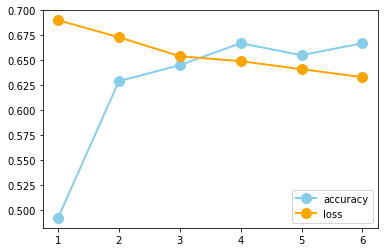

In [23]:
df=pd.DataFrame({'x': range(1,7), 'loss': [0.690, 0.673, 0.654, 0.649, 0.641, 0.633], 'accuracy': [0.492, 0.629, 0.645, 0.667, 0.655, 0.667]})
 
plt.plot( 'x', 'accuracy', data=df, marker='o', markerfacecolor='skyblue', markersize=10, color='skyblue', linewidth=2)
plt.plot( 'x', 'loss', data=df, marker='o', markerfacecolor='orange', markersize=10, color='orange', linewidth=2)
plt.legend()

# III. Zero shot learning for every alphabet with NN trained on pseudo alphabet

In [16]:
name = pseudo_alphabets[5][0]
features = pseudo_alphabets[5][1]
y = pseudo_alphabets[5][2]

print("\n" + name)
X = pd.DataFrame(features, columns = list('abcdefghig'))
X = normalize_data(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=27)

print("Fitting in progress...")
pseudo_model = nn_model(10)
pseudo_model.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose = 0, validation_split=0.2)

print("Evaluation: " + str(pseudo_model.evaluate(X_test, y_test, verbose = 0)))


Alphabet 0l 7c
Fitting in progress...
Evaluation: [0.4247915832368075, 0.808726003573619]


In [17]:
for name, features, y in alphabets:
    print("\n" + name)
    
    X = pd.DataFrame(features, columns = list('abcdefghig'))
    X = normalize_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=27)
    
    print("Evaluation on pseudo model: " + str(pseudo_model.evaluate(X_test, y_test, verbose = 0)))


Cyrillic
Evaluation on pseudo model: [0.7758576368242266, 0.6478053939399235]

Alphabet of the Magi
Evaluation on pseudo model: [0.8375588017597533, 0.5666666666666667]

Futurama
Evaluation on pseudo model: [0.7411698318701648, 0.6149405772495755]

Japanese (Katakana)
Evaluation on pseudo model: [0.8683641474491998, 0.553090633250205]

Sanskrit
Evaluation on pseudo model: [0.7107506904922367, 0.6401780038901521]

Armenian
Evaluation on pseudo model: [0.8233069303030838, 0.5752861756259547]


# IV. Zero shot learning for every alphabet using Reptile on pseudo alphabets

In [53]:
def reptile_pseudo(alphabets):
    num_iters = 7
    k = 10
    sample_size = 1000
    lr = 0.1

    reptile_model = nn_model(10)
    W = reptile_model.get_weights()

    for name, features, y in alphabets:

        print('Updating NN weights with: ' + name)

        X = pd.DataFrame(features, columns = list('abcdefghig'))
        X = normalize_data(X)
        
        X_full, X_eval, y_full, y_eval = train_test_split(X, y, test_size = 0.3, random_state=27)

        for iteration in range(num_iters):
           
            sample_indices = random.sample(range(len(X_full)), sample_size)
            X_sample = np.array([X_full[index] for index in sample_indices])
            y_sample = np.array([y_full[index] for index in sample_indices])

            new_model = nn_model(10)
            new_model.set_weights(W)
            new_model.fit(X_sample, y_sample, epochs = k, batch_size = 1, verbose = 0)
            _W = new_model.get_weights()

            step_size = lr * (1 - iteration / num_iters) 
            delta = np.subtract(_W, W) * step_size

            W = [sum(i) for i in zip(W, delta)] 

    reptile_model.set_weights(W)
    return reptile_model

In [54]:
reptile_pseudo_model = reptile_pseudo(pseudo_alphabets)

Updating NN weights with: Alphabet 2l 5c
Updating NN weights with: Alphabet 4l 2c
Updating NN weights with: Alphabet 4l 4c
Updating NN weights with: Alphabet 5l 1c
Updating NN weights with: Alphabet 7l 3c
Updating NN weights with: Alphabet 0l 7c


In [55]:
for name, features, y in alphabets:
    print("\n" + name)
    
    X = pd.DataFrame(features, columns = list('abcdefghig'))
    X = normalize_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=27)
    
    print("Evaluation on pseudo Reptile model: " + str(reptile_pseudo_model.evaluate(X, y, verbose = 0)))


Cyrillic
Evaluation on pseudo Reptile model: [0.7189999025302635, 0.6170871013992082]

Alphabet of the Magi
Evaluation on pseudo Reptile model: [0.8514774565320266, 0.5657894736842105]

Futurama
Evaluation on pseudo Reptile model: [0.7850433568549411, 0.5844116148994822]

Japanese (Katakana)
Evaluation on pseudo Reptile model: [0.8656192137758566, 0.5310046649220617]

Sanskrit
Evaluation on pseudo Reptile model: [0.6970228742746761, 0.6275669146201033]

Armenian
Evaluation on pseudo Reptile model: [0.8090986813915191, 0.5750770585277647]
